In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from google.colab import files

In [4]:
!pip install optuna

In [5]:
import optuna  # For automated hyperparameter tuning
import shap  # For explainable AI

# Step 1: Load the dataset
uploaded = files.upload()
data = pd.read_csv("emissions_high_granularity.csv")

Saving emissions_high_granularity.csv to emissions_high_granularity (1).csv


In [6]:


# Step 2: Feature Engineering
# Adding additional features (simulated for this example)
data["temperature"] = np.random.uniform(15, 35, size=len(data))  # Simulated weather data
data["process_efficiency"] = np.random.uniform(0.8, 1.0, size=len(data))  # Efficiency metric
data["equipment_age"] = np.random.randint(1, 20, size=len(data))  # Equipment aging
data["renewable_energy_share"] = np.random.uniform(0, 50, size=len(data))  # % renewable integration

# Include new features in the model
features = [
    "production_value",
    "product_emissions_MtCO2",
    "flaring_emissions_MtCO2",
    "venting_emissions_MtCO2",
    "own_fuel_use_emissions_MtCO2",
    "fugitive_methane_emissions_MtCO2e",
    "temperature",
    "process_efficiency",
    "equipment_age",
    "renewable_energy_share",
]
target = "total_emissions_MtCO2e"

In [7]:
# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(data[features])
feature_names_poly = poly.get_feature_names_out(features)

In [8]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, data[target], test_size=0.2, random_state=42)


In [9]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Step 3: Hyperparameter Tuning with Optuna (Random Forest Example)
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }
    model = RandomForestRegressor(random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

# Train the best Random Forest model
model = RandomForestRegressor(random_state=42, **best_params)
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Random Forest - MAE: {mae}, R² Score: {r2}")

[I 2025-01-25 11:05:40,545] A new study created in memory with name: no-name-36863983-7ede-4704-ad90-d9368f22e886
[I 2025-01-25 11:08:56,081] Trial 0 finished with value: 1.2604964888532275 and parameters: {'n_estimators': 230, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.2604964888532275.
[I 2025-01-25 11:11:03,433] Trial 1 finished with value: 1.4766870526526927 and parameters: {'n_estimators': 171, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.2604964888532275.
[I 2025-01-25 11:12:33,190] Trial 2 finished with value: 1.5292721239379996 and parameters: {'n_estimators': 122, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 10}. Best is trial 0 with value: 1.2604964888532275.
[I 2025-01-25 11:13:18,760] Trial 3 finished with value: 0.7176293185457803 and parameters: {'n_estimators': 51, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 3 with va

Optimized Random Forest - MAE: 0.6166198166803064, R² Score: 0.9988599631164372


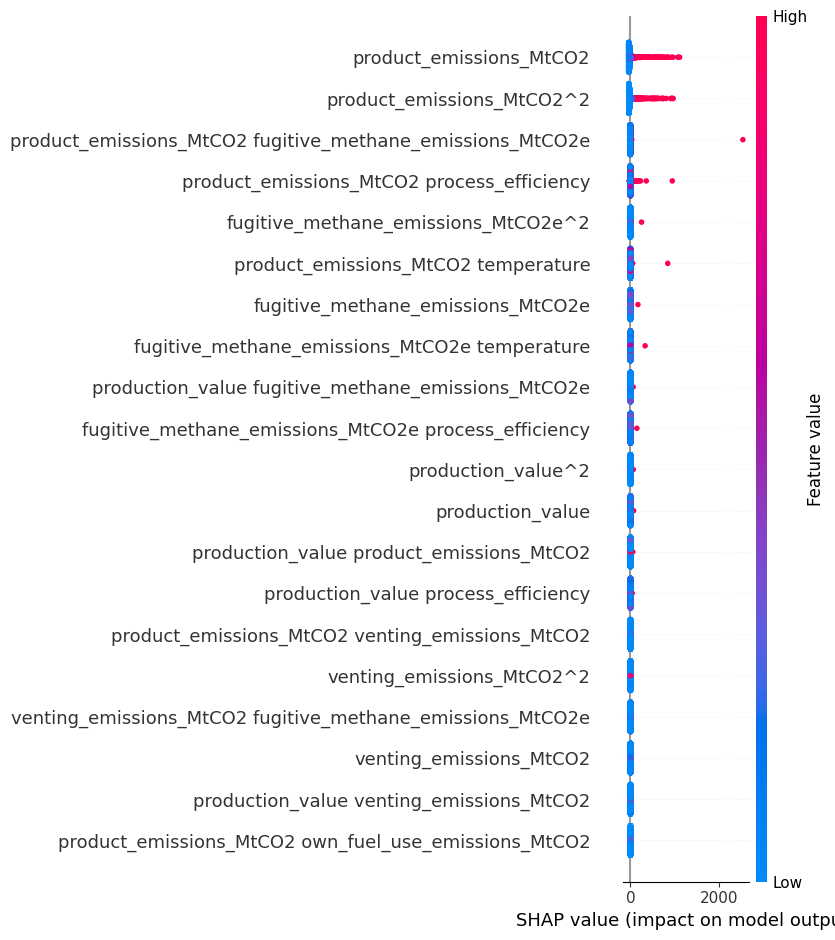

In [12]:
# Step 4: Explainable AI with SHAP
# Use TreeExplainer for Random Forest models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Generate SHAP summary plot
shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values, X_test_scaled, feature_names=feature_names_poly)

In [14]:
# Step 5: Optimization with Weighted Objective
def weighted_objective_function(inputs):
    # Transform inputs to match the polynomial feature space
    inputs_df = pd.DataFrame([inputs], columns=features)  # Create a DataFrame for the original features
    inputs_poly = poly.transform(inputs_df)  # Apply polynomial transformation
    inputs_scaled = scaler.transform(inputs_poly)  # Ensure inputs are scaled

    predicted_emissions = model.predict(inputs_scaled)[0]  # Predict using the model

    # Define weights only for original features (rest are set to 0)
    weights = [0.2, 0.3, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05] + [0] * (len(inputs_poly[0]) - len(features))
    weighted_emissions = sum(w * x for w, x in zip(weights, inputs_poly[0]))  # Apply weights to polynomial features

    return predicted_emissions + weighted_emissions

# Adjusted Bounds for Optimization
bounds = [
    (0.9 * data["production_value"].mean(), 1.1 * data["production_value"].mean()),
    (0, data["product_emissions_MtCO2"].max()),
    (0, data["flaring_emissions_MtCO2"].max()),
    (0, data["venting_emissions_MtCO2"].max()),
    (0, data["own_fuel_use_emissions_MtCO2"].max()),
    (0, data["fugitive_methane_emissions_MtCO2e"].max()),
    (15, 35),  # Temperature bounds
    (0.8, 1.0),  # Process efficiency bounds
    (1, 20),  # Equipment age bounds
    (0, 50),  # Renewable energy share bounds
]

# Define Constraints
def constraint_production(inputs):
    min_production = 0.9 * data["production_value"].mean()
    return inputs[0] - min_production

constraints = [
    {"type": "ineq", "fun": constraint_production},
]

# Run the Optimization
initial_guess = data[features].mean().values  # Use the mean values of the original features
result = minimize(
    weighted_objective_function,
    initial_guess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# Extract the optimized inputs and emissions
optimized_inputs = result.x
optimized_emissions = result.fun

# Display the results
print("\nOptimized Inputs:")
for feature, value in zip(features, optimized_inputs):
    print(f"{feature}: {value:.2f}")
print(f"Optimized Emissions: {optimized_emissions:.2f} MtCO2e")



Optimized Inputs:
production_value: 295.09
product_emissions_MtCO2: 0.00
flaring_emissions_MtCO2: 0.00
venting_emissions_MtCO2: 0.00
own_fuel_use_emissions_MtCO2: 0.00
fugitive_methane_emissions_MtCO2e: 0.00
temperature: 15.00
process_efficiency: 0.80
equipment_age: 1.00
renewable_energy_share: 0.00
Optimized Emissions: 59.88 MtCO2e


In [15]:
# Step 6: What-If Scenarios
scenarios = {
    "10% Reduction in Venting": optimized_inputs.copy(),
    "15% Reduction in Flaring": optimized_inputs.copy(),
}
scenarios["10% Reduction in Venting"][3] *= 0.9  # Reduce venting emissions by 10%
scenarios["15% Reduction in Flaring"][2] *= 0.85  # Reduce flaring emissions by 15%

for scenario, inputs in scenarios.items():
    # Transform and scale the inputs for prediction
    inputs_df = pd.DataFrame([inputs], columns=features)
    inputs_poly = poly.transform(inputs_df)
    inputs_scaled = scaler.transform(inputs_poly)

    # Predict emissions using the optimized model
    emissions = model.predict(inputs_scaled)[0]
    print(f"{scenario}: {emissions:.2f} MtCO2e")

10% Reduction in Venting: 0.02 MtCO2e
15% Reduction in Flaring: 0.02 MtCO2e


In [16]:
import joblib  # For saving models as .pkl files

# Save the trained RandomForest model
joblib.dump(model, "random_forest_model.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Save the polynomial feature transformer
joblib.dump(poly, "polynomial_features.pkl")


['polynomial_features.pkl']